# Install TensorFlow

In [ ]:

!pip install tensorflow

# Verify TensorFlow installation
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.17.1


# Import required libraries

In [ ]:

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the dataset (values between 0 and 1)
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot encode labels
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

# Print dataset shapes
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
x_train shape: (50000, 32, 32, 3), y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3), y_test shape: (10000, 10)


#  model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Define a shallow neural network model
def build_model():
    model = Sequential([
        Flatten(input_shape=(32, 32, 3)),  # Flatten the input images to a 1D vector
        Dense(128, activation='relu'),     # Hidden layer 1 with 265 units
        Dense(10, activation='softmax')    # Output layer with 10 units (one for each CIFAR-10 class)
    ])
    return model


# optimizers & learning rate schedulers Definition

In [ ]:
from tensorflow.keras.optimizers import SGD, RMSprop, Nadam
import numpy as np
from tensorflow.keras.callbacks import LearningRateScheduler
import time
# Define Learning Rate Schedulers
def step_decay(epoch):
    initial_lr = 0.01
    drop = 0.5
    epochs_drop = 10
    return initial_lr * (drop ** np.floor(epoch / epochs_drop))

def exponential_decay(epoch):
    initial_lr = 0.01
    k = 0.1
    return initial_lr * np.exp(-k * epoch)

# Define Optimizers
optimizers = {
    "SGD (Warm Restarts)": SGD(learning_rate=0.01, momentum=0.9, nesterov=False),
    "NAG": SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    "RMSProp": RMSprop(learning_rate=0.001),
    "Nadam": Nadam(learning_rate=0.001)
}


# Training function


In [ ]:
def train_model(optimizer_class, optimizer_name, scheduler=None, epochs=100, batch_size=128):
    model = build_model()

    optimizer = optimizer_class(learning_rate=0.01) if optimizer_name != "RMSProp" else optimizer_class(learning_rate=0.001)

    callbacks = [LearningRateScheduler(scheduler)] if scheduler else []

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                        epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=0)
    training_time = time.time() - start_time
    return model, history, training_time


#Confusion Matrix FN


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure inline plots
%matplotlib inline

# Function to calculate and plot confusion matrix
def plot_confusion_matrix(model, x_test, y_test, optimizer_name):
    # Predict the labels for x_test
    y_pred = model.predict(x_test)
    # Convert predictions and true labels to class labels (not probabilities)
    y_pred_classes = y_pred.argmax(axis=1)
    y_true_classes = y_test.argmax(axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    disp.plot(cmap='viridis')  # Set colormap for better visualization
    plt.title(f"Confusion Matrix for {optimizer_name}")
    plt.show()



# Training with SGD (Warm Restarts) and No Scheduler

Training SGD (Warm Restarts) with No Scheduler...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


SGD (Warm Restarts) training time: 118.34 seconds
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


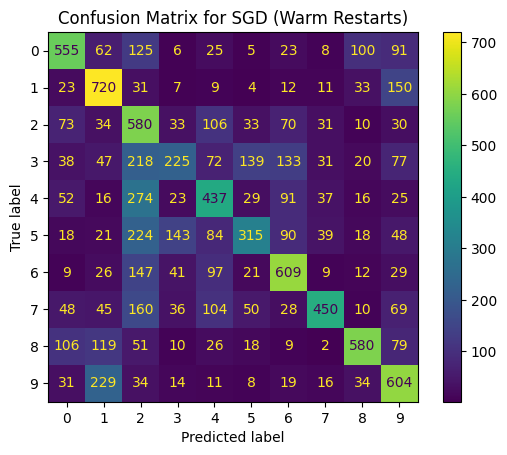

In [ ]:
print("Training SGD (Warm Restarts) with No Scheduler...")
trained_model, history_sgd, time_sgd = train_model(SGD, "SGD (Warm Restarts)", scheduler=None, epochs=100)
print(f"SGD (Warm Restarts) training time: {time_sgd:.2f} seconds")

# Plot confusion matrix using the trained model
plot_confusion_matrix(trained_model, x_test, y_test, "SGD (Warm Restarts)")


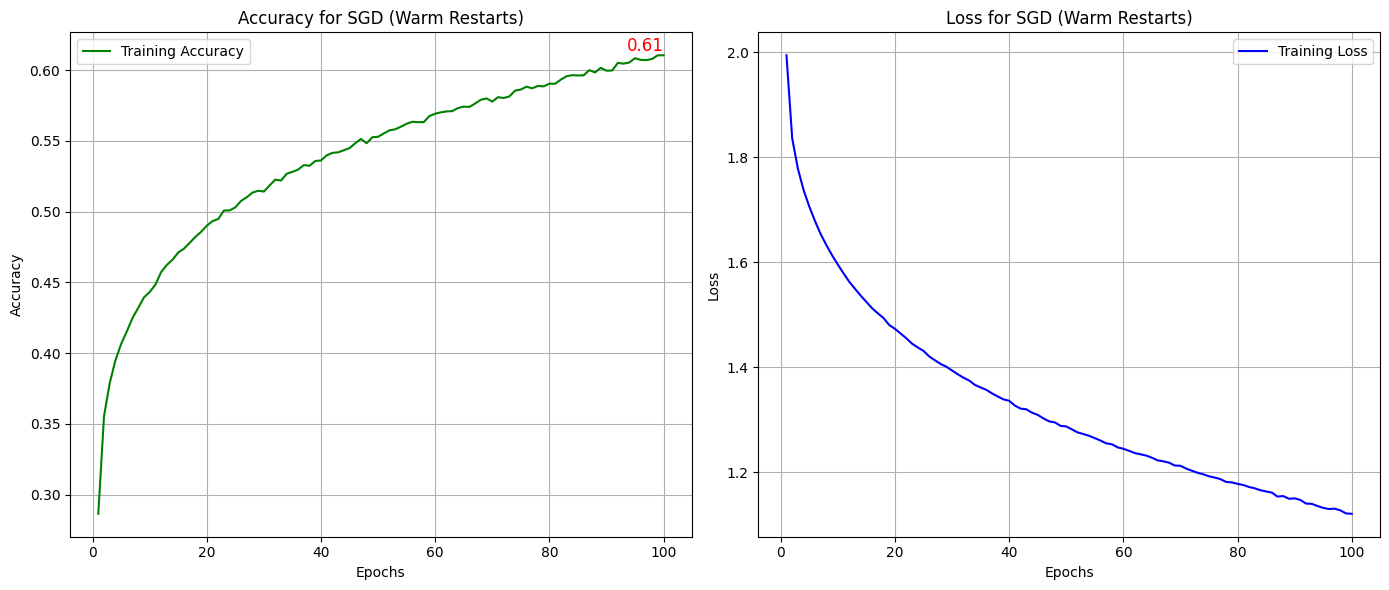

In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss side by side
def plot_accuracy_and_loss_side_by_side(history, optimizer_name):
    epochs = range(1, len(history.history['accuracy']) + 1)
    final_accuracy = history.history['accuracy'][-1]  # Get final training accuracy

    # Create a figure with two subplots
    plt.figure(figsize=(14, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='', color='green')
    plt.title(f'Accuracy for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Annotate final accuracy
    plt.text(len(epochs), final_accuracy, f'{final_accuracy:.2f}', fontsize=12, color='red',
             horizontalalignment='right', verticalalignment='bottom')

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='', color='blue')
    plt.title(f'Loss for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot side-by-side accuracy and loss graphs
plot_accuracy_and_loss_side_by_side(history_sgd, "SGD (Warm Restarts)")


# Training with SGD (Warm Restarts) and Step Decay Scheduler


Training SGD (Warm Restarts) with Step Decay Scheduler...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


SGD (Warm Restarts with Step Decay) training time: 120.82 seconds
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


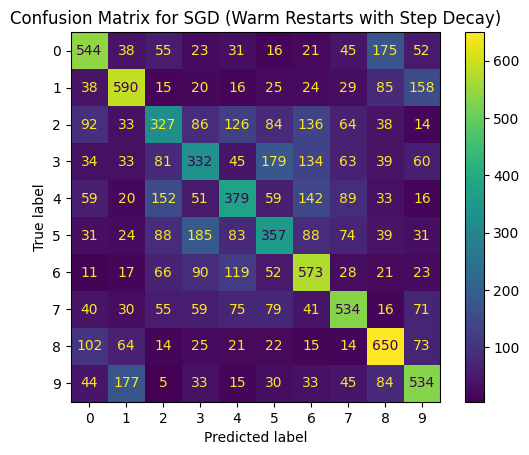

In [ ]:
# Training with SGD (Warm Restarts) and Step Decay Scheduler
print("Training SGD (Warm Restarts) with Step Decay Scheduler...")

# Train the model with SGD and Step Decay Scheduler
trained_model, history_sgd_step, time_sgd_step = train_model(
    optimizer_class=SGD,
    optimizer_name="SGD (Warm Restarts)",
    scheduler=step_decay,
    epochs=100
)

print(f"SGD (Warm Restarts with Step Decay) training time: {time_sgd_step:.2f} seconds")

# Plot confusion matrix using the trained model
plot_confusion_matrix(trained_model, x_test, y_test, "SGD (Warm Restarts with Step Decay)")


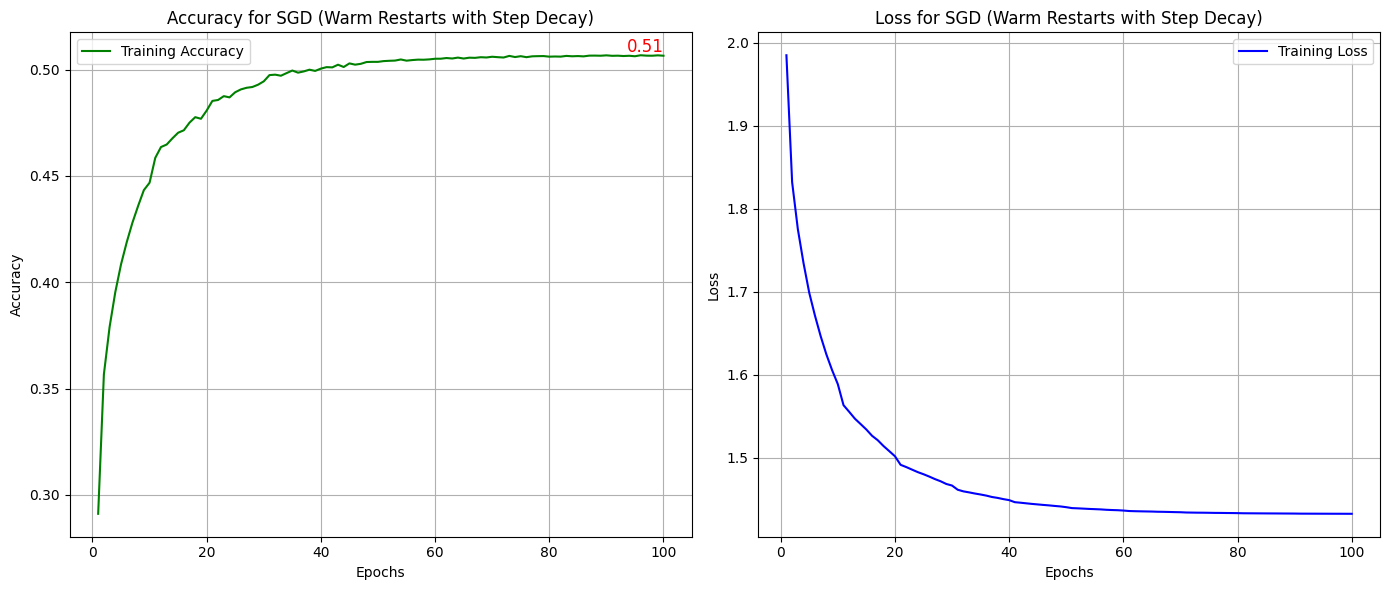

In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss side by side
def plot_accuracy_and_loss_side_by_side(history, optimizer_name):
    epochs = range(1, len(history.history['accuracy']) + 1)
    final_accuracy = history.history['accuracy'][-1]  # Get final training accuracy

    # Create a figure with two subplots
    plt.figure(figsize=(14, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='', color='green')
    plt.title(f'Accuracy for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Annotate final accuracy at the end of the graph
    plt.text(len(epochs), final_accuracy, f'{final_accuracy:.2f}', fontsize=12, color='red',
             horizontalalignment='right', verticalalignment='bottom')

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='', color='blue')
    plt.title(f'Loss for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot side-by-side accuracy and loss graphs
plot_accuracy_and_loss_side_by_side(history_sgd_step, "SGD (Warm Restarts with Step Decay)")


# Training with SGD (Warm Restarts) and Exponential Decay Scheduler


Training SGD (Warm Restarts) with Exponential Decay Scheduler...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


SGD (Warm Restarts with Exponential Decay) training time: 117.38 seconds
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


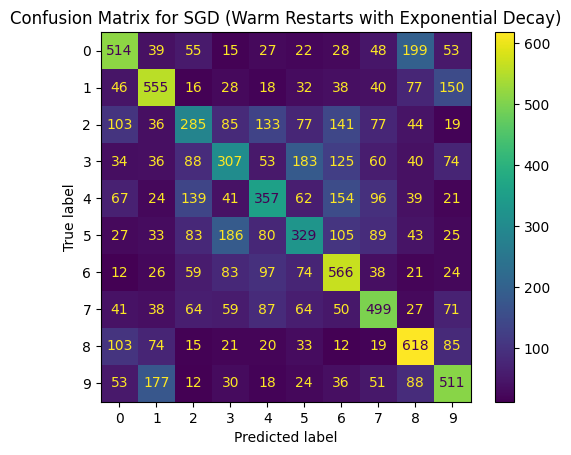

In [ ]:
# Training with SGD (Warm Restarts) and Exponential Decay Scheduler
print("Training SGD (Warm Restarts) with Exponential Decay Scheduler...")

# Train the model with SGD and Exponential Decay Scheduler
trained_model, history_sgd_exp, time_sgd_exp = train_model(
    optimizer_class=SGD,
    optimizer_name="SGD (Warm Restarts)",
    scheduler=exponential_decay,
    epochs=100
)

print(f"SGD (Warm Restarts with Exponential Decay) training time: {time_sgd_exp:.2f} seconds")

# Plot confusion matrix using the trained model
plot_confusion_matrix(trained_model, x_test, y_test, "SGD (Warm Restarts with Exponential Decay)")


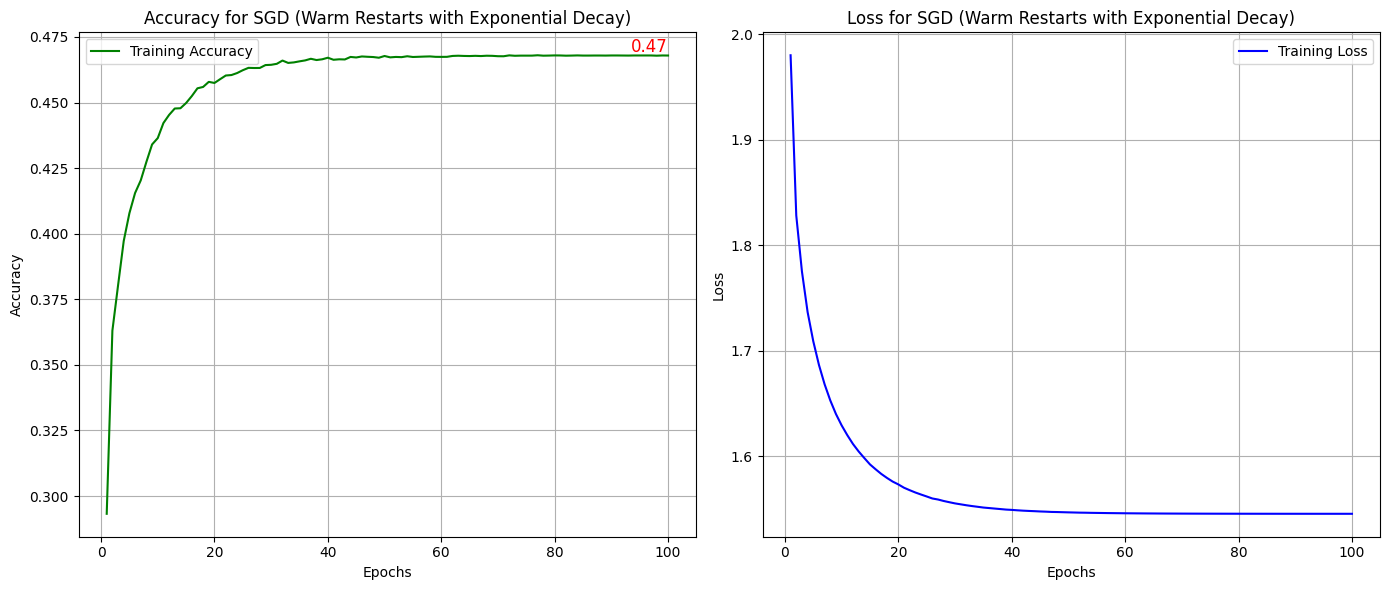

In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss side by side
def plot_accuracy_and_loss_side_by_side(history, optimizer_name):
    epochs = range(1, len(history.history['accuracy']) + 1)
    final_accuracy = history.history['accuracy'][-1]  # Get final training accuracy

    # Create a figure with two subplots
    plt.figure(figsize=(14, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='', color='green')
    plt.title(f'Accuracy for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Annotate final accuracy
    plt.text(len(epochs), final_accuracy, f'{final_accuracy:.2f}', fontsize=12, color='red',
             horizontalalignment='right', verticalalignment='bottom')

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='', color='blue')
    plt.title(f'Loss for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot side-by-side accuracy and loss graphs
plot_accuracy_and_loss_side_by_side(history_sgd_exp, "SGD (Warm Restarts with Exponential Decay)")


# Training with NAG and No Scheduler


Training NAG Scheduler...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


NAG training time: 113.86 seconds
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


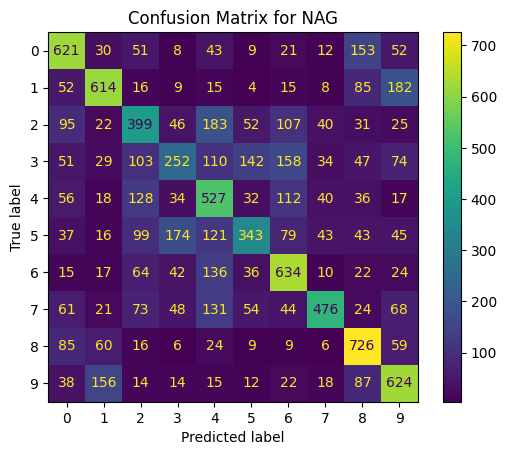

In [ ]:
# Training with NAG and NO Scheduler
print("Training NAG Scheduler...")

# Train the model with NAG and NO Scheduler
trained_model, history_nag, time_nag = train_model(
    optimizer_class=SGD,
    optimizer_name="NAG",
    scheduler=None,
    epochs=100
)

print(f"NAG training time: {time_nag:.2f} seconds")

# Plot confusion matrix using the trained model
plot_confusion_matrix(trained_model, x_test, y_test, "NAG")


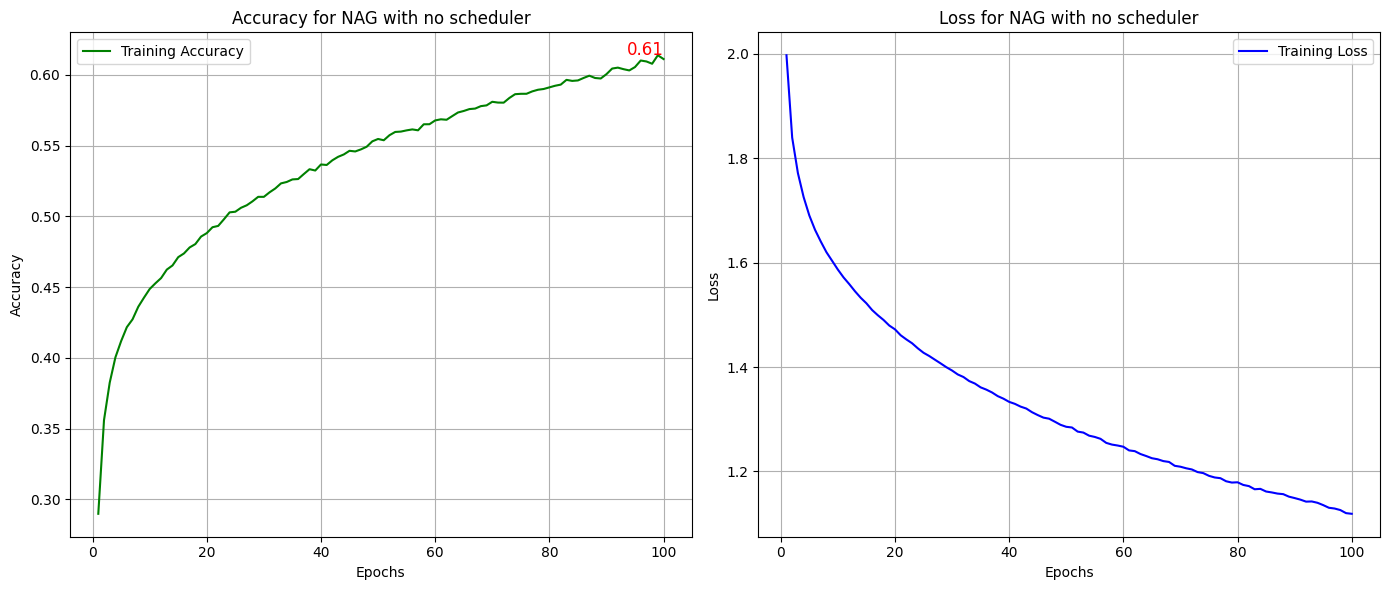

In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss side by side
def plot_accuracy_and_loss_side_by_side(history, optimizer_name):
    epochs = range(1, len(history.history['accuracy']) + 1)
    final_accuracy = history.history['accuracy'][-1]  # Get final training accuracy

    # Create a figure with two subplots
    plt.figure(figsize=(14, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='', color='green')
    plt.title(f'Accuracy for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Annotate final accuracy
    plt.text(len(epochs), final_accuracy, f'{final_accuracy:.2f}', fontsize=12, color='red',
             horizontalalignment='right', verticalalignment='bottom')

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='', color='blue')
    plt.title(f'Loss for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot side-by-side accuracy and loss graphs
plot_accuracy_and_loss_side_by_side(history_nag, "NAG with no scheduler")


# Training with NAG and Step Decay Scheduler

Training NAG with Step Decay scheduler...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


NAG with Step Decay scheduler training time: 110.85 seconds
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


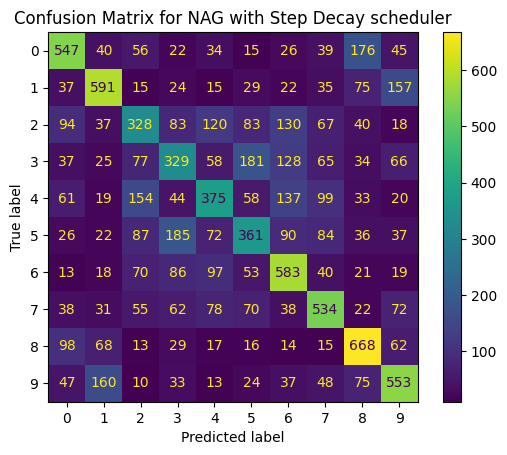

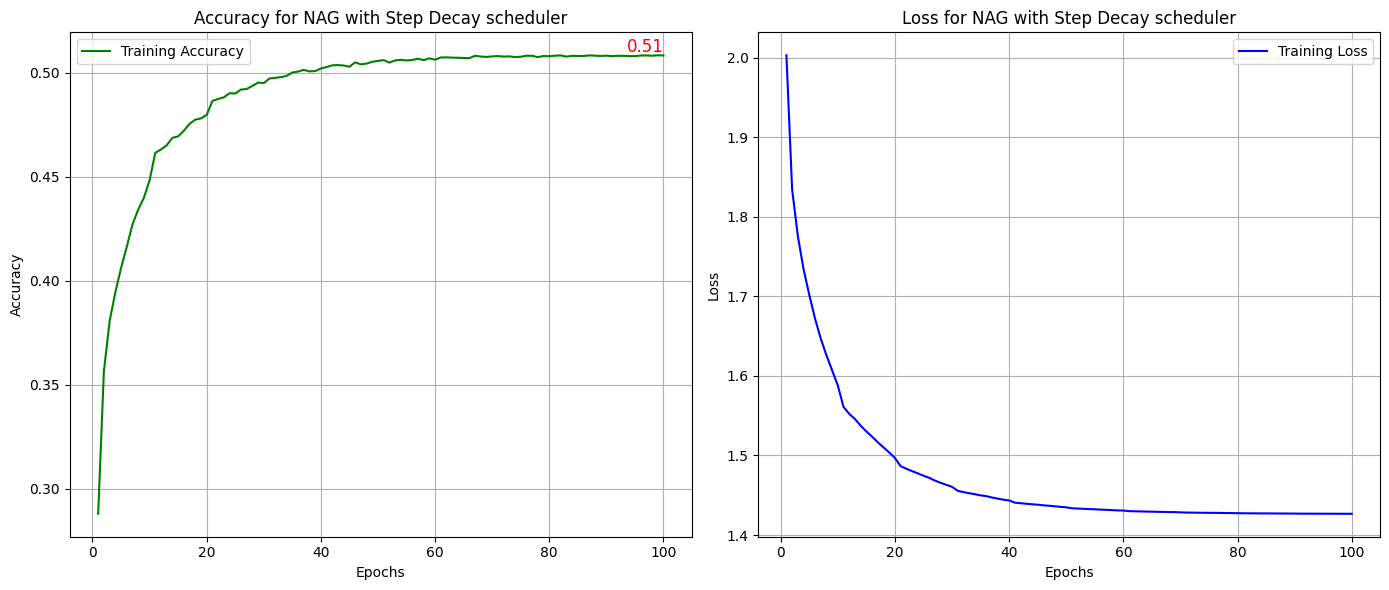

In [ ]:
# Training with NAG and Step Decay Scheduler
print("Training NAG with Step Decay scheduler...")

# Train the model with NAG and Step Decay Scheduler
trained_model, history_nag_step, time_nag_step = train_model(
    optimizer_class=SGD,
    optimizer_name="NAG",
    scheduler=step_decay,
    epochs=100
)

print(f"NAG with Step Decay scheduler training time: {time_nag_step:.2f} seconds")

# Plot confusion matrix using the trained model
plot_confusion_matrix(trained_model, x_test, y_test, "NAG with Step Decay scheduler")


import matplotlib.pyplot as plt

# Function to plot accuracy and loss side by side
def plot_accuracy_and_loss_side_by_side(history, optimizer_name):
    epochs = range(1, len(history.history['accuracy']) + 1)
    final_accuracy = history.history['accuracy'][-1]  # Get final training accuracy

    # Create a figure with two subplots
    plt.figure(figsize=(14, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='', color='green')
    plt.title(f'Accuracy for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Annotate final accuracy
    plt.text(len(epochs), final_accuracy, f'{final_accuracy:.2f}', fontsize=12, color='red',
             horizontalalignment='right', verticalalignment='bottom')

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='', color='blue')
    plt.title(f'Loss for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot side-by-side accuracy and loss graphs
plot_accuracy_and_loss_side_by_side(history_nag_step, "NAG with Step Decay scheduler")



# Training with NAG and Exponential Decay Scheduler


Training NAG with Exponential Decay scheduler...
NAG with Exponential Decay scheduler training time: 120.43 seconds
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


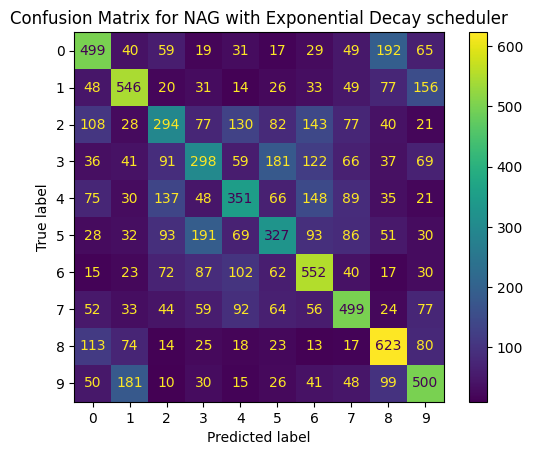

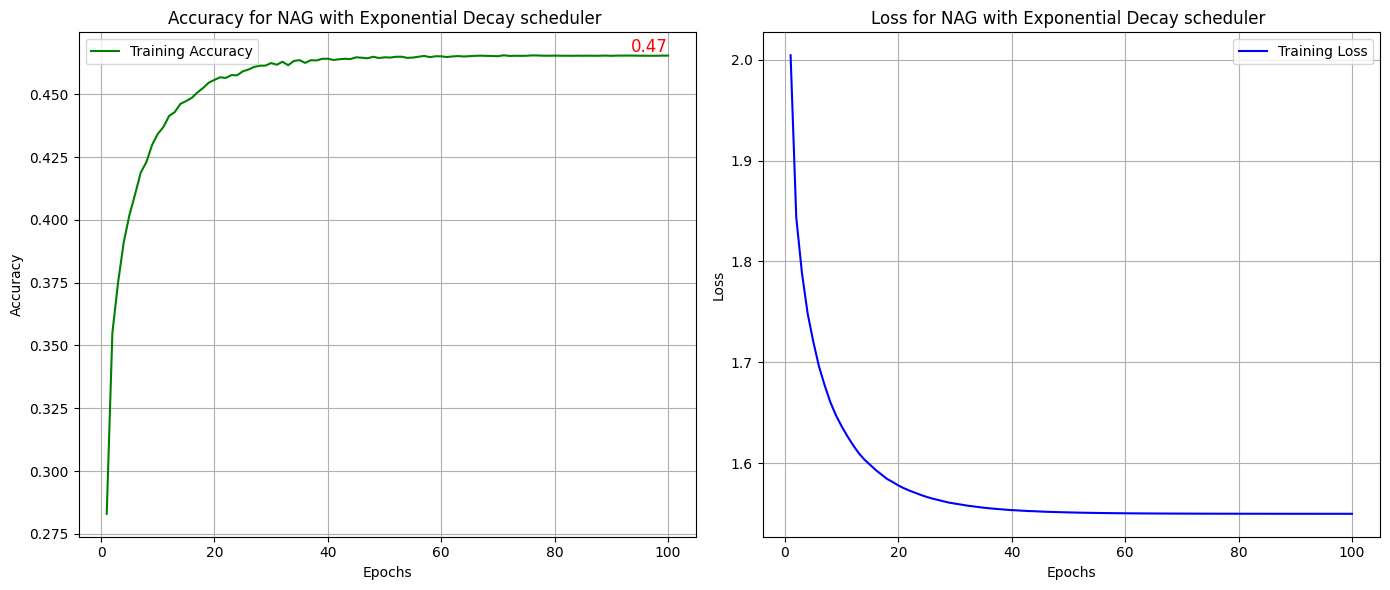

In [ ]:
# Training with NAG and Exponential Decay Scheduler
print("Training NAG with Exponential Decay scheduler...")

# Train the model with NAG and Step Decay Scheduler
trained_model, history_nag_exp, time_nag_exp = train_model(
    optimizer_class=SGD,
    optimizer_name="NAG",
    scheduler=exponential_decay ,
    epochs=100
)

print(f"NAG with Exponential Decay scheduler training time: {time_nag_exp:.2f} seconds")

# Plot confusion matrix using the trained model
plot_confusion_matrix(trained_model, x_test, y_test, "NAG with Exponential Decay scheduler")


import matplotlib.pyplot as plt

# Function to plot accuracy and loss side by side
def plot_accuracy_and_loss_side_by_side(history, optimizer_name):
    epochs = range(1, len(history.history['accuracy']) + 1)
    final_accuracy = history.history['accuracy'][-1]  # Get final training accuracy

    # Create a figure with two subplots
    plt.figure(figsize=(14, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='', color='green')
    plt.title(f'Accuracy for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

 # Annotate final accuracy
    plt.text(len(epochs), final_accuracy, f'{final_accuracy:.2f}', fontsize=12, color='red',
             horizontalalignment='right', verticalalignment='bottom')

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='', color='blue')
    plt.title(f'Loss for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()


# Plot side-by-side accuracy and loss graphs
plot_accuracy_and_loss_side_by_side(history_nag_exp, "NAG with Exponential Decay scheduler ")


# Training with RMSProp and No Scheduler

Training RMSProp Scheduler...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSProp training time: 115.88 seconds
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


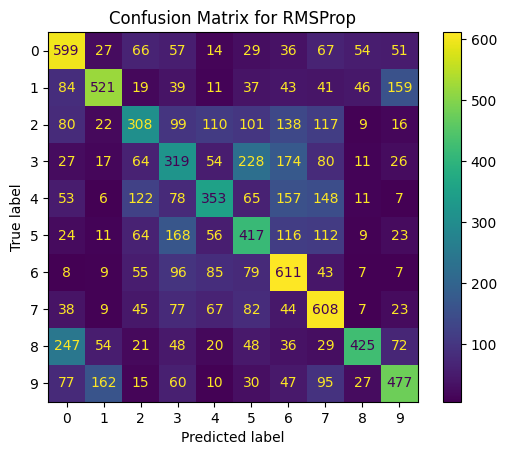

In [ ]:
# Training with RMSProp and NO Scheduler
print("Training RMSProp Scheduler...")

# Train the model with RMSProp and NO Scheduler
trained_model, history_rms, time_rms = train_model(
    optimizer_class=RMSprop,
    optimizer_name="RMSProp",
    scheduler=None,
    epochs=100
)

print(f"RMSProp training time: {time_rms:.2f} seconds")

# Plot confusion matrix using the trained model
plot_confusion_matrix(trained_model, x_test, y_test, "RMSProp")


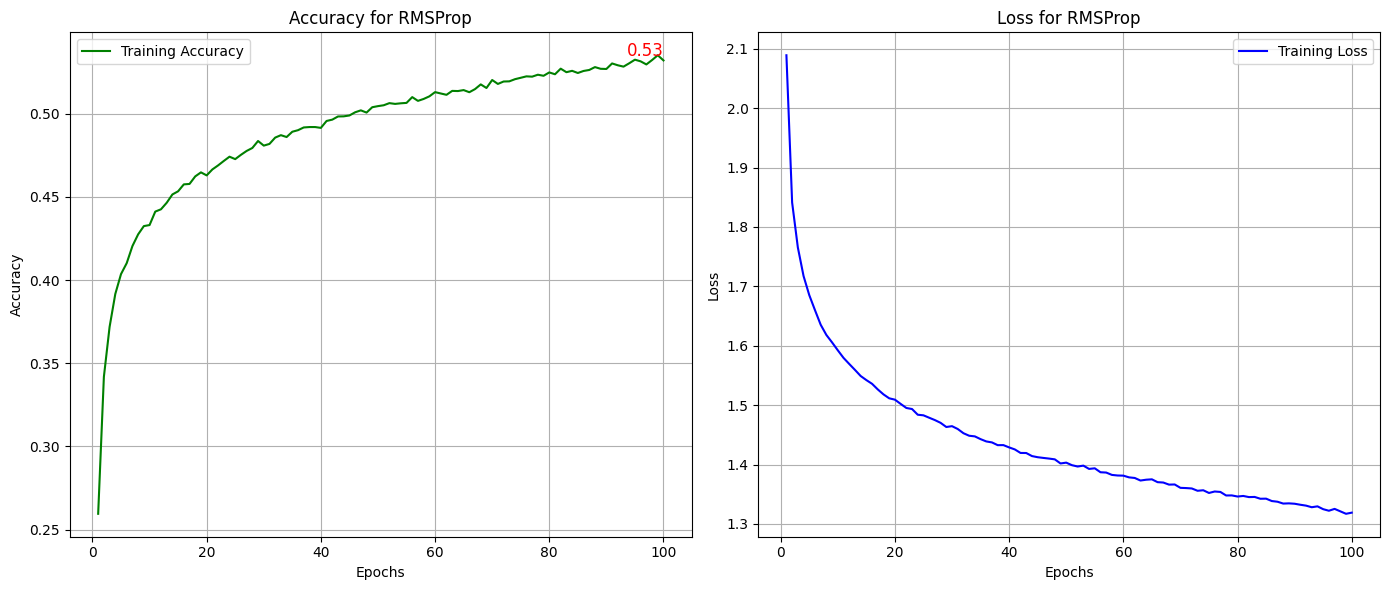

In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss side by side
def plot_accuracy_and_loss_side_by_side(history, optimizer_name):
    epochs = range(1, len(history.history['accuracy']) + 1)
    final_accuracy = history.history['accuracy'][-1]  # Get final training accuracy

    # Create a figure with two subplots
    plt.figure(figsize=(14, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='', color='green')
    plt.title(f'Accuracy for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Annotate final accuracy
    plt.text(len(epochs), final_accuracy, f'{final_accuracy:.2f}', fontsize=12, color='red',
             horizontalalignment='right', verticalalignment='bottom')

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='', color='blue')
    plt.title(f'Loss for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot side-by-side accuracy and loss graphs
plot_accuracy_and_loss_side_by_side(history_rms, "RMSProp")



# Training with RMSProp and Step Decay Scheduler




Training RMSProp and step decay Scheduler...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSProp with step decay sch training time: 121.03 seconds
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


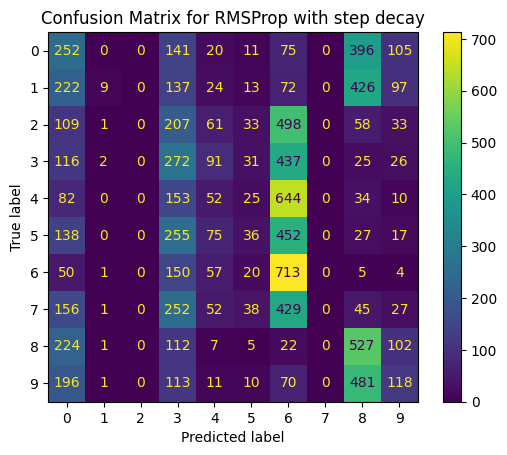

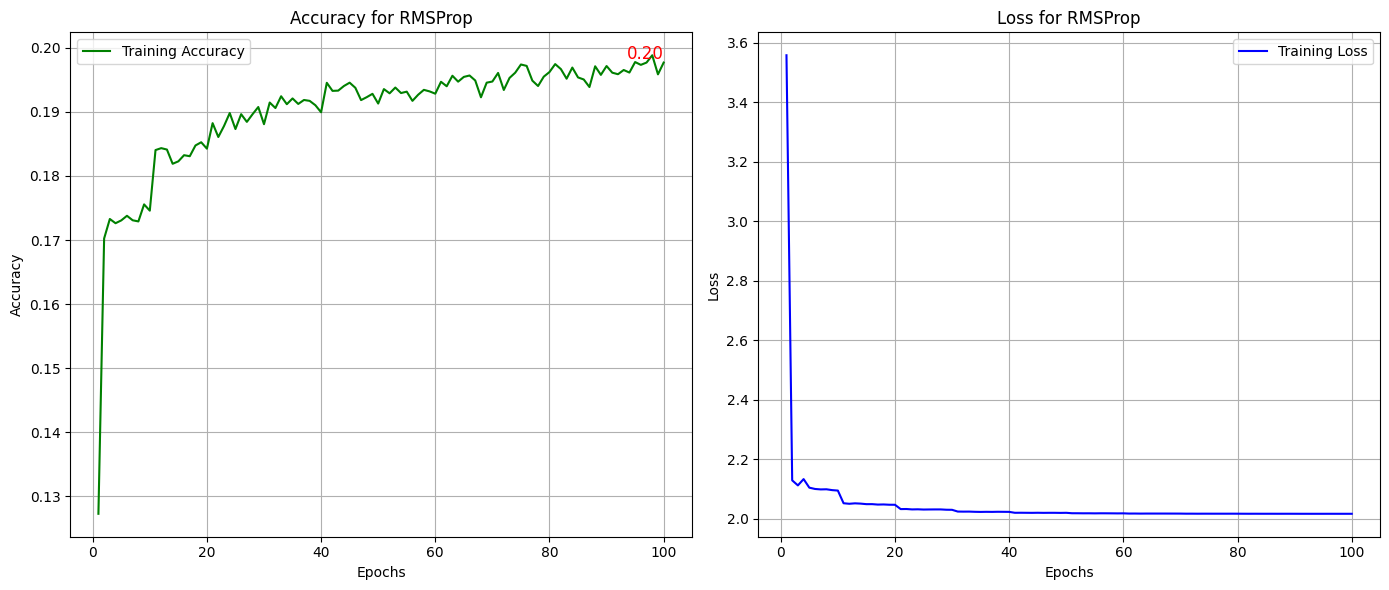

In [ ]:
# Training with RMSProp and STEP decay Scheduler
print("Training RMSProp and step decay Scheduler...")

# Train the model with RMSProp and step Scheduler
trained_model, history_rms_step, time_rms_step = train_model(
    optimizer_class=RMSprop,
    optimizer_name="RMSProp",
    scheduler=step_decay,
    epochs=100
)

print(f"RMSProp with step decay sch training time: {time_rms_step:.2f} seconds")

# Plot confusion matrix using the trained model
plot_confusion_matrix(trained_model, x_test, y_test, "RMSProp with step decay")



import matplotlib.pyplot as plt

# Function to plot accuracy and loss side by side
def plot_accuracy_and_loss_side_by_side(history, optimizer_name):
    epochs = range(1, len(history.history['accuracy']) + 1)
    final_accuracy = history.history['accuracy'][-1]  # Get final training accuracy

    # Create a figure with two subplots
    plt.figure(figsize=(14, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='', color='green')
    plt.title(f'Accuracy for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Annotate final accuracy
    plt.text(len(epochs), final_accuracy, f'{final_accuracy:.2f}', fontsize=12, color='red',
             horizontalalignment='right', verticalalignment='bottom')

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='', color='blue')
    plt.title(f'Loss for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot side-by-side accuracy and loss graphs
plot_accuracy_and_loss_side_by_side(history_rms_step, "RMSProp")




# Training with RMSProp and Exponential Decay Scheduler

Training RMSProp and Exponential decay Scheduler...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSProp with Exponential decay sch training time: 118.11 seconds
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


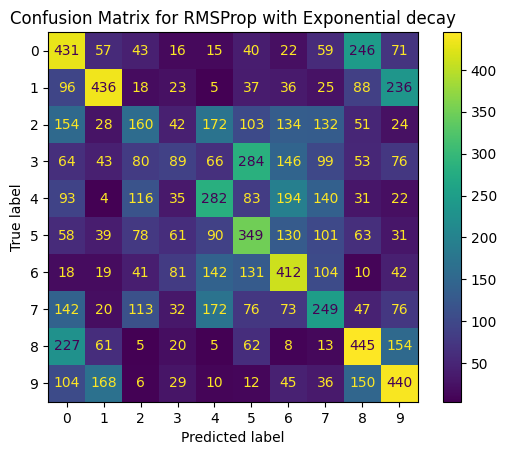

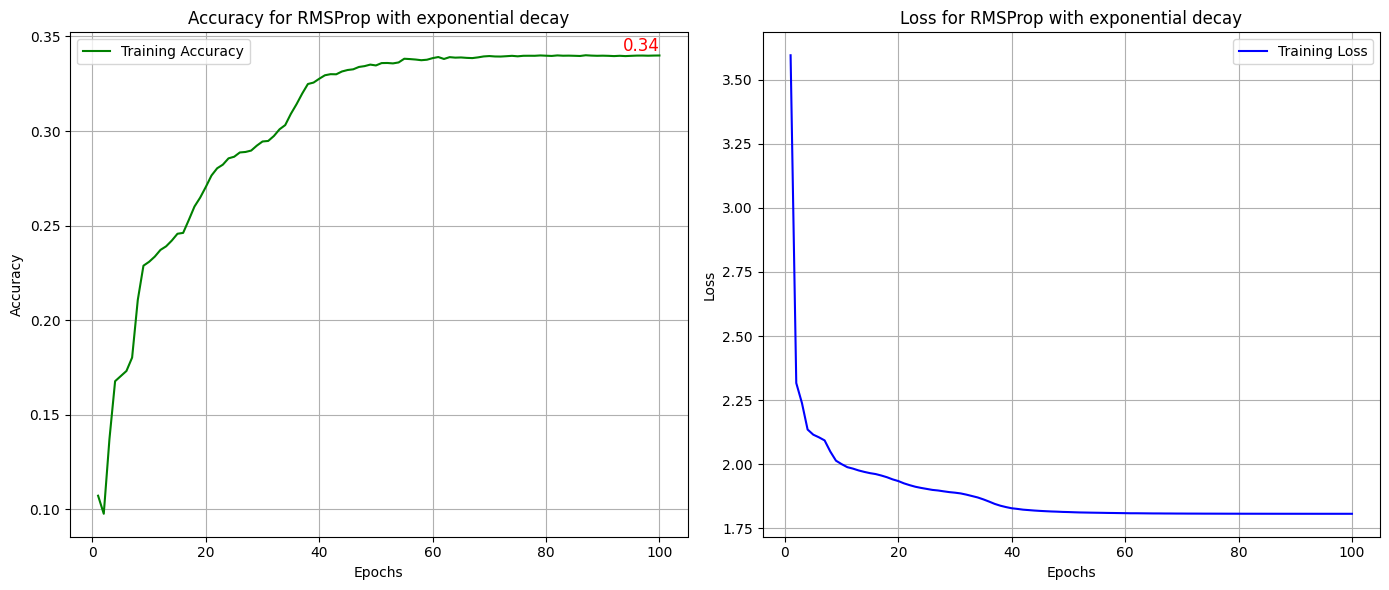

In [ ]:
# Training with RMSProp and Exponential decay Scheduler
print("Training RMSProp and Exponential decay Scheduler...")

# Train the model with RMSProp and Exponential Scheduler
trained_model, history_rms_exp, time_rms_exp = train_model(
    optimizer_class=RMSprop,
    optimizer_name="RMSProp",
    scheduler=exponential_decay,
    epochs=100
)

print(f"RMSProp with Exponential decay sch training time: {time_rms_exp:.2f} seconds")

# Plot confusion matrix using the trained model
plot_confusion_matrix(trained_model, x_test, y_test, "RMSProp with Exponential decay")



import matplotlib.pyplot as plt

# Function to plot accuracy and loss side by side
def plot_accuracy_and_loss_side_by_side(history, optimizer_name):
    epochs = range(1, len(history.history['accuracy']) + 1)
    final_accuracy = history.history['accuracy'][-1]  # Get final training accuracy

    # Create a figure with two subplots
    plt.figure(figsize=(14, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='', color='green')
    plt.title(f'Accuracy for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Annotate final accuracy
    plt.text(len(epochs), final_accuracy, f'{final_accuracy:.2f}', fontsize=12, color='red',
             horizontalalignment='right', verticalalignment='bottom')

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='', color='blue')
    plt.title(f'Loss for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot side-by-side accuracy and loss graphs
plot_accuracy_and_loss_side_by_side(history_rms_exp, "RMSProp with exponential decay")




# Training with Nadam and No Scheduler

Training NADAM with no scheduler...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


NADAM training time: 119.97 seconds
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


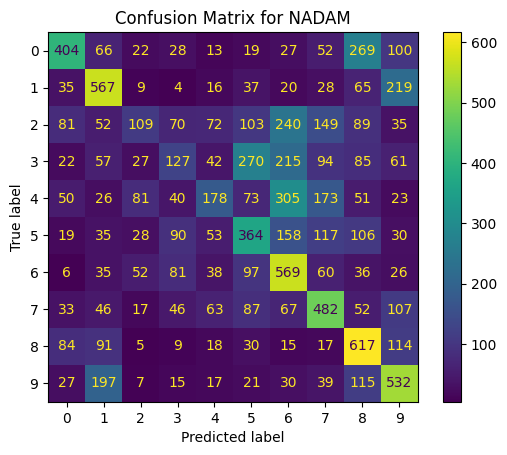

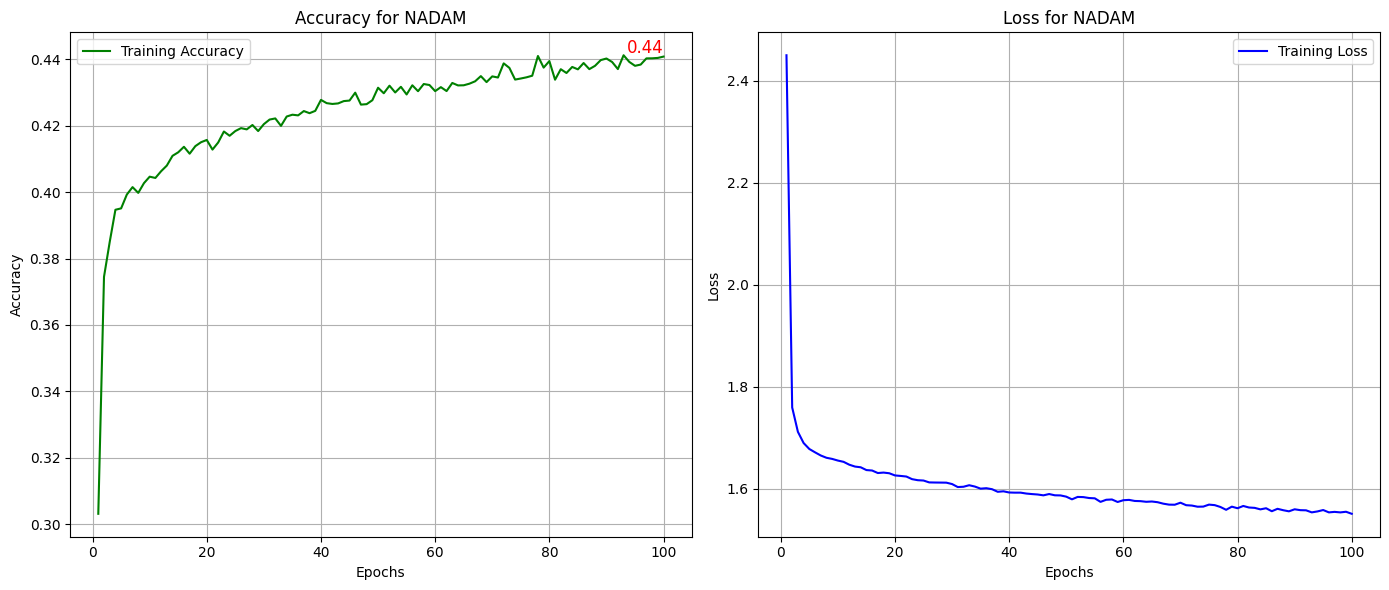

In [ ]:
# Training with NADAM and NO Scheduler
print("Training NADAM with no scheduler...")

# Train the model with NADAM and NO Scheduler
trained_model, history_nadam, time_nadam = train_model(
    optimizer_class=Nadam,
    optimizer_name="Nadam",
    scheduler=None,
    epochs=100
)

print(f"NADAM training time: {time_nadam:.2f} seconds")

# Plot confusion matrix using the trained model
plot_confusion_matrix(trained_model, x_test, y_test, "NADAM")


import matplotlib.pyplot as plt

# Function to plot accuracy and loss side by side
def plot_accuracy_and_loss_side_by_side(history, optimizer_name):
    epochs = range(1, len(history.history['accuracy']) + 1)
    final_accuracy = history.history['accuracy'][-1]  # Get final training accuracy

    # Create a figure with two subplots
    plt.figure(figsize=(14, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='', color='green')
    plt.title(f'Accuracy for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Annotate final accuracy
    plt.text(len(epochs), final_accuracy, f'{final_accuracy:.2f}', fontsize=12, color='red',
             horizontalalignment='right', verticalalignment='bottom')

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='', color='blue')
    plt.title(f'Loss for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot side-by-side accuracy and loss graphs
plot_accuracy_and_loss_side_by_side(history_nadam, "NADAM")



# Training with Nadam and Step Decay Scheduler


Training NADAM with Step Decay scheduler...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


NADAM with Step Decay scheduler training time: 123.35 seconds
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


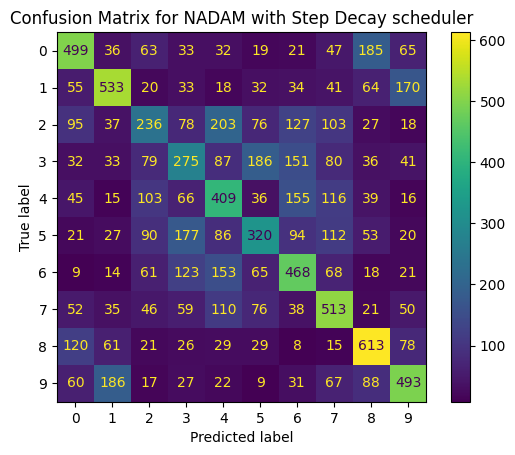

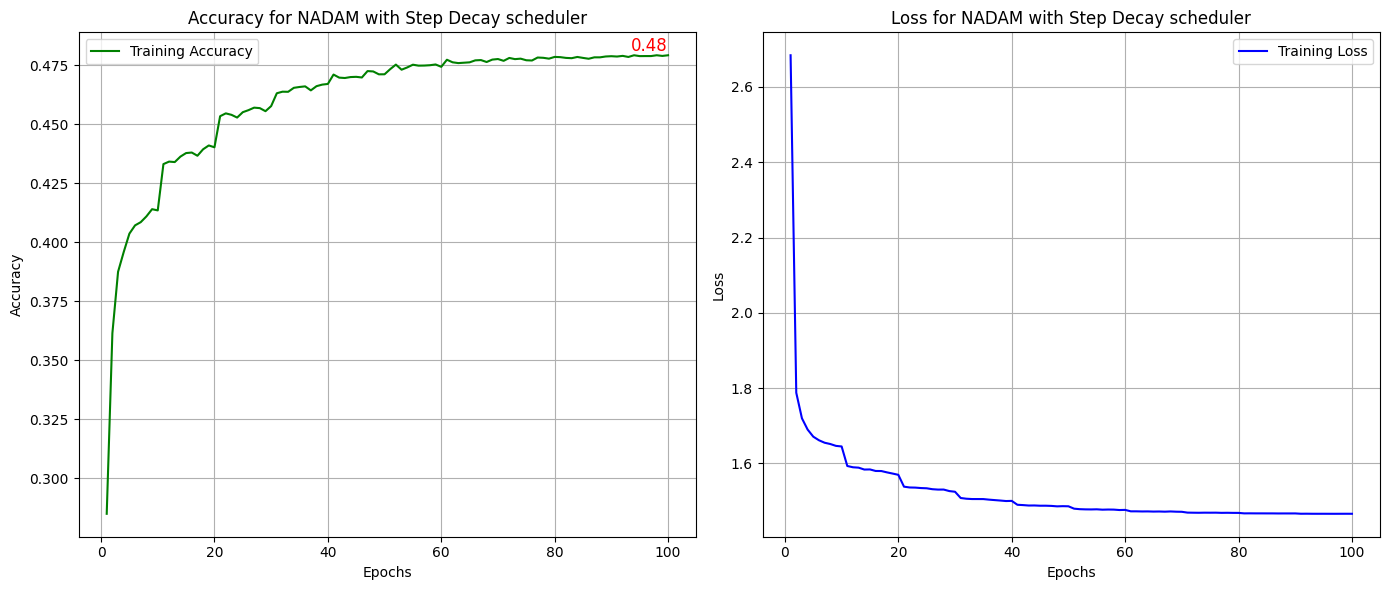

In [ ]:
# Training with NADAM and Step Decay Scheduler
print("Training NADAM with Step Decay scheduler...")

# Train the model with NADAM and Step Decay Scheduler
trained_model, history_nadam_step, time_nadam_step = train_model(
    optimizer_class=Nadam,
    optimizer_name="Nadam",
    scheduler=step_decay,
    epochs=100
)

print(f"NADAM with Step Decay scheduler training time: {time_nadam_step:.2f} seconds")

# Plot confusion matrix using the trained model
plot_confusion_matrix(trained_model, x_test, y_test, "NADAM with Step Decay scheduler")


import matplotlib.pyplot as plt

# Function to plot accuracy and loss side by side
def plot_accuracy_and_loss_side_by_side(history, optimizer_name):
    epochs = range(1, len(history.history['accuracy']) + 1)
    final_accuracy = history.history['accuracy'][-1]  # Get final training accuracy

    # Create a figure with two subplots
    plt.figure(figsize=(14, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='', color='green')
    plt.title(f'Accuracy for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Annotate final accuracy
    plt.text(len(epochs), final_accuracy, f'{final_accuracy:.2f}', fontsize=12, color='red',
             horizontalalignment='right', verticalalignment='bottom')

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='', color='blue')
    plt.title(f'Loss for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot side-by-side accuracy and loss graphs
plot_accuracy_and_loss_side_by_side(history_nadam_step, "NADAM with Step Decay scheduler")



# Training with Nadam and Exponential Decay Scheduler


Training NADAM with Exponential Decay scheduler...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


NADAM with Exponential Decay scheduler training time: 121.87 seconds
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


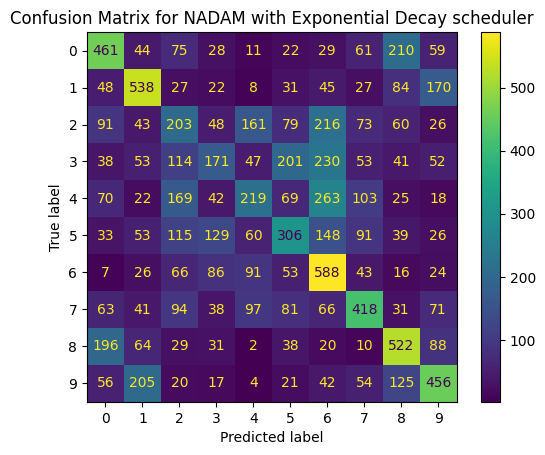

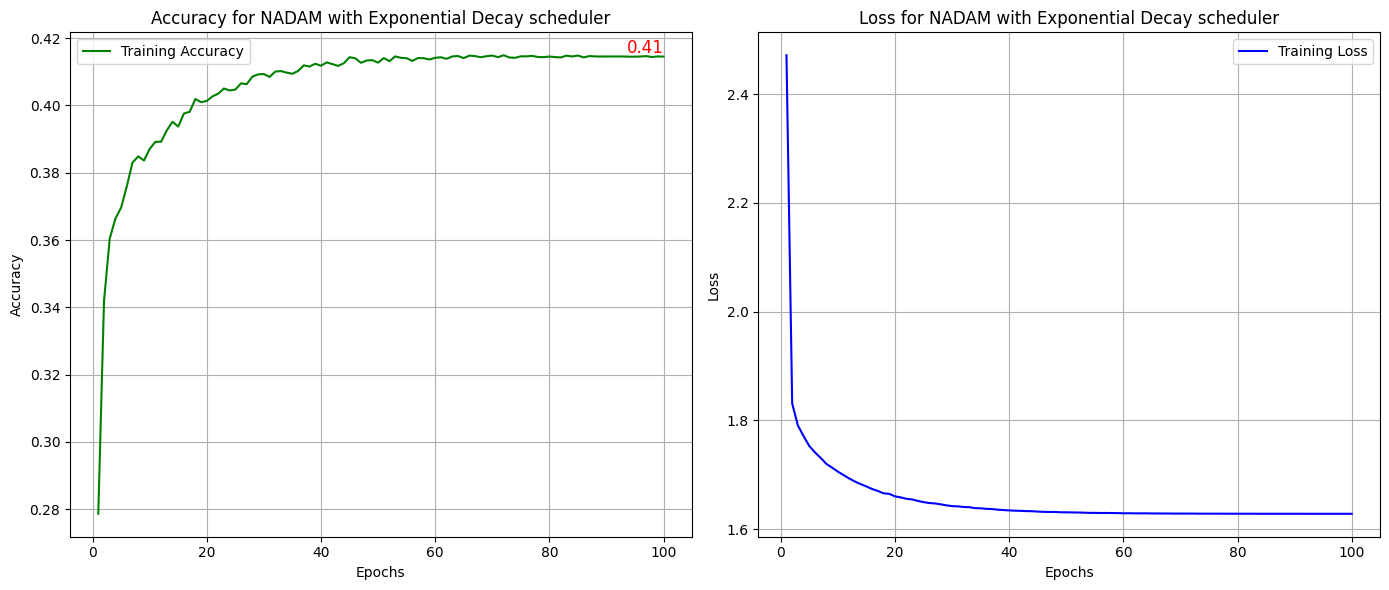

In [ ]:
# Training with NADAM and Exponential Decay Scheduler
print("Training NADAM with Exponential Decay scheduler...")

# Train the model with NADAM and Exponential Decay Scheduler
trained_model, history_nadam_exp, time_nadam_exp = train_model(
    optimizer_class=Nadam,
    optimizer_name="Nadam",
    scheduler=exponential_decay,
    epochs=100
)

print(f"NADAM with Exponential Decay scheduler training time: {time_nadam_exp:.2f} seconds")

# Plot confusion matrix using the trained model
plot_confusion_matrix(trained_model, x_test, y_test, "NADAM with Exponential Decay scheduler")


import matplotlib.pyplot as plt

# Function to plot accuracy and loss side by side
def plot_accuracy_and_loss_side_by_side(history, optimizer_name):
    epochs = range(1, len(history.history['accuracy']) + 1)
    final_accuracy = history.history['accuracy'][-1]  # Get final training accuracy

    # Create a figure with two subplots
    plt.figure(figsize=(14, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='', color='green')
    plt.title(f'Accuracy for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Annotate final accuracy
    plt.text(len(epochs), final_accuracy, f'{final_accuracy:.2f}', fontsize=12, color='red',
             horizontalalignment='right', verticalalignment='bottom')

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='', color='blue')
    plt.title(f'Loss for {optimizer_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot side-by-side accuracy and loss graphs
plot_accuracy_and_loss_side_by_side(history_nadam_exp, "NADAM with Exponential Decay scheduler")



#Performance comparison between all optimizers

In [ ]:
import matplotlib.pyplot as plt

# Plot training accuracy comparison for all optimizers and schedulers
plt.figure(figsize=(12, 8))

# Plot training accuracy for each optimizer and scheduler
plt.plot(history_sgd.history['accuracy'], label='SGD (Warm Restarts)', linestyle='-')  # Solid line
plt.plot(history_sgd_step.history['accuracy'], label='SGD with Step Decay', linestyle='-')  # Solid line
plt.plot(history_sgd_exp.history['accuracy'], label='SGD with Exponential Decay', linestyle='-')  # Solid line

plt.plot(history_nag.history['accuracy'], label='NAG (No Scheduler)', linestyle='--')  # Dashed linee
plt.plot(history_nag_step.history['accuracy'], label='NAG with Step Decay', linestyle='--')  # Dashed line
plt.plot(history_nag_exp.history['accuracy'], label='NAG with Exponential Decay', linestyle='--')  # Dashed line

plt.plot(history_rms.history['accuracy'], label='RMSProp (No Scheduler)', linestyle='-')  # Solid line
plt.plot(history_rms_step.history['accuracy'], label='RMSProp with Step Decay', linestyle='-')  # Dashed line
plt.plot(history_rms_exp.history['accuracy'], label='RMSProp with Exponential Decay', linestyle='-')  # Dotted line

plt.plot(history_nadam.history['accuracy'], label='Nadam (No Scheduler)', linestyle='-.')  # center line
plt.plot(history_nadam_step.history['accuracy'], label='Nadam with Step Decay', linestyle='-.')  # center line
plt.plot(history_nadam_exp.history['accuracy'], label='Nadam with Exponential Decay', linestyle='-.')  # center line

# Customize the plot
plt.title('Training Accuracy Comparison of Optimizers with Different Schedulers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



NameError: name 'history_sgd' is not defined

<Figure size 1200x800 with 0 Axes>

#Plot training time comparison

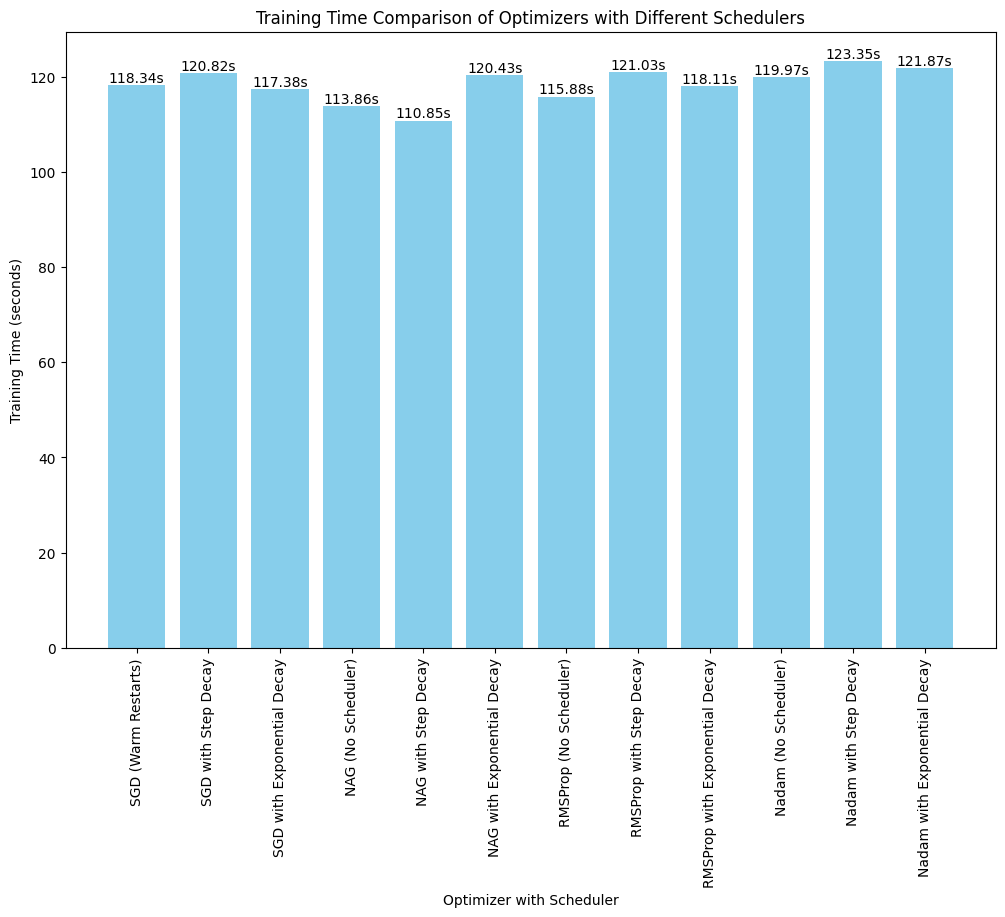

In [ ]:
optimizer_names = ['SGD', 'NAG', 'RMSProp', 'Nadam']
scheduler_names = ['No Scheduler', 'Step Decay', 'Exponential Decay']
training_times = {
    'SGD (Warm Restarts)': time_sgd,
    'SGD with Step Decay': time_sgd_step,
    'SGD with Exponential Decay': time_sgd_exp,
    'NAG (No Scheduler)': time_nag,
    'NAG with Step Decay': time_nag_step,
    'NAG with Exponential Decay': time_nag_exp,
    'RMSProp (No Scheduler)': time_rms,
    'RMSProp with Step Decay': time_rms_step,
    'RMSProp with Exponential Decay': time_rms_exp,
    'Nadam (No Scheduler)': time_nadam,
    'Nadam with Step Decay': time_nadam_step,
    'Nadam with Exponential Decay': time_nadam_exp
}

# Create a bar plot for training times
plt.figure(figsize=(12, 8))
bars = plt.bar(training_times.keys(), training_times.values(), color='skyblue')

# Add time in seconds on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x-coordinate at the center of the bar
        height,                            # y-coordinate slightly above the bar
        f'{height:.2f}s',                  # Text to display
        ha='center',                       # Horizontal alignment
        va='bottom',                       # Vertical alignment
        fontsize=10                        # Font size
    )

plt.title('Training Time Comparison of Optimizers with Different Schedulers')
plt.xlabel('Optimizer with Scheduler')
plt.ylabel('Training Time (seconds)')
plt.xticks(rotation=90)
plt.show()



# Plot class distributions


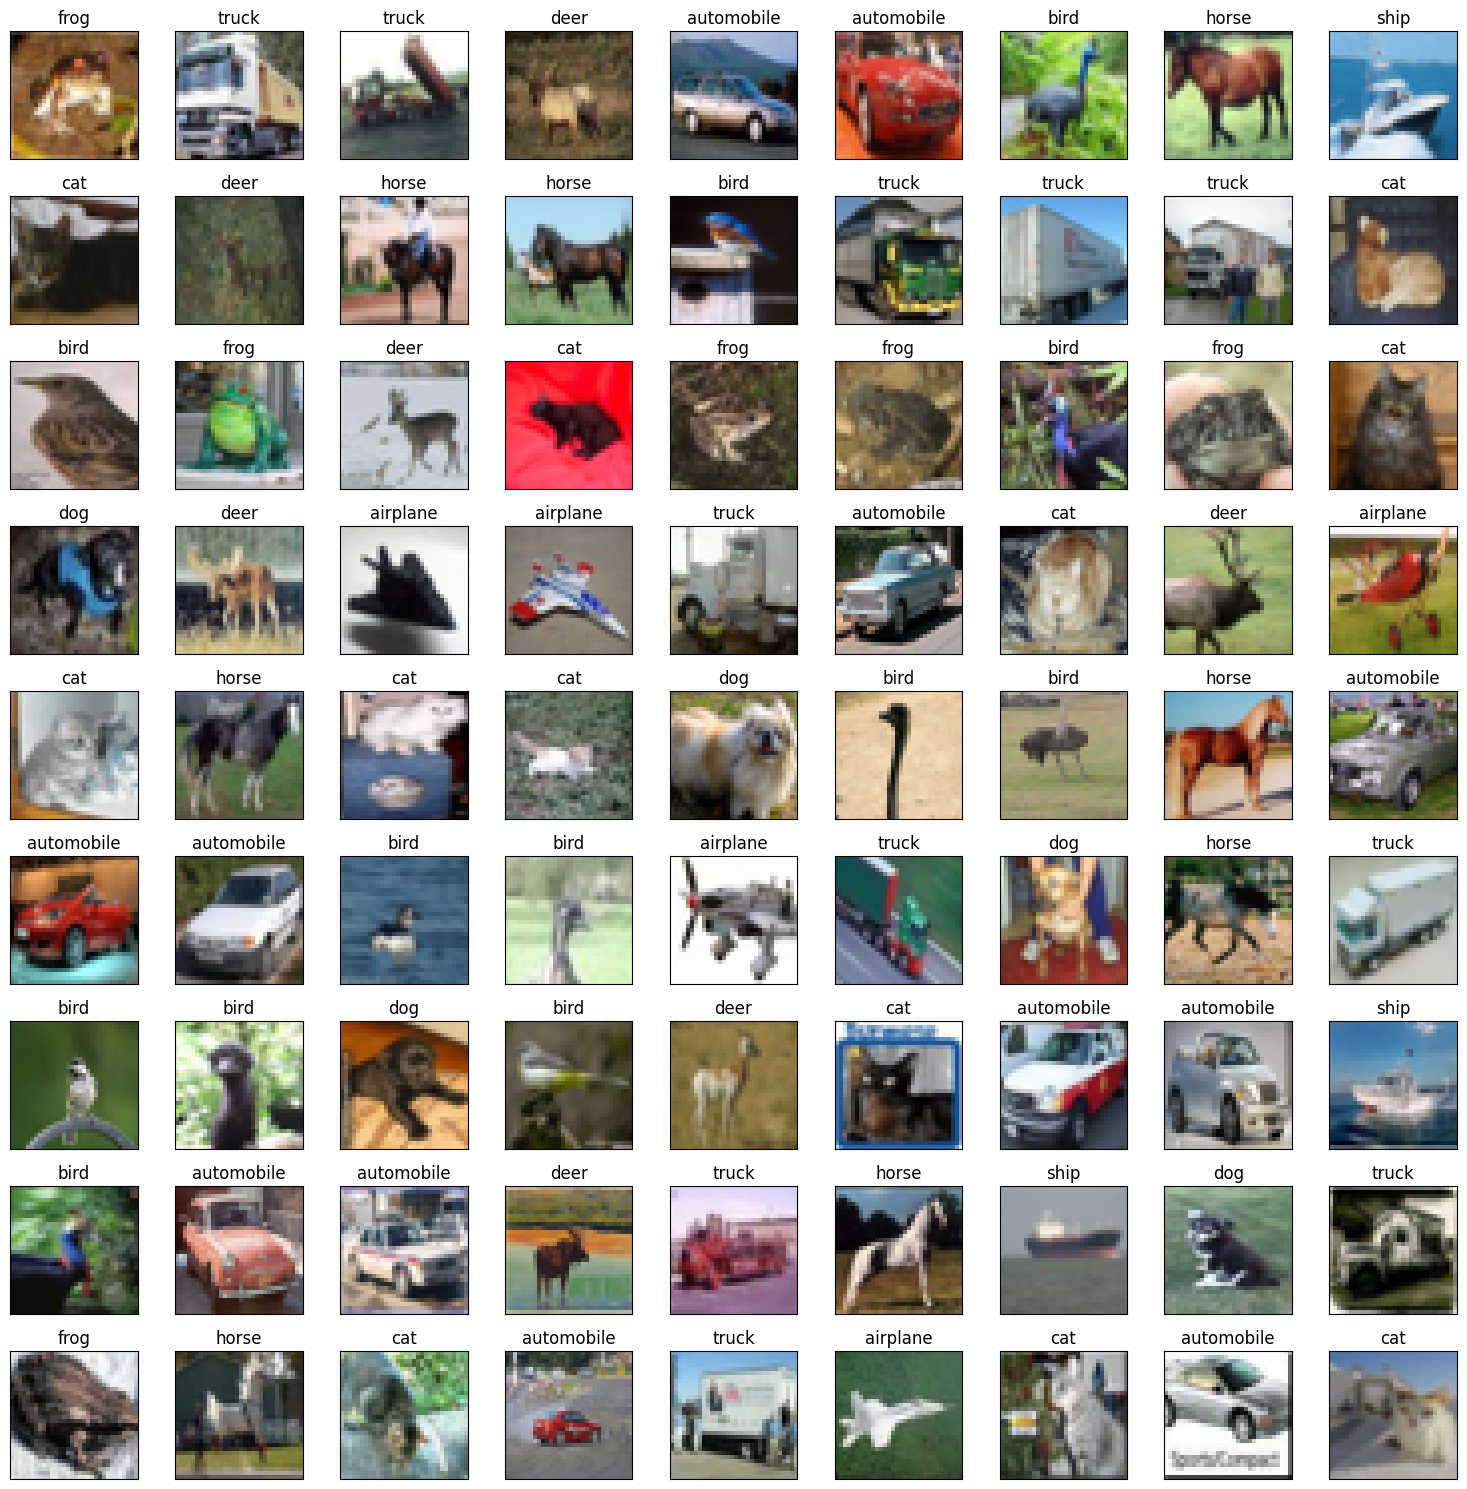

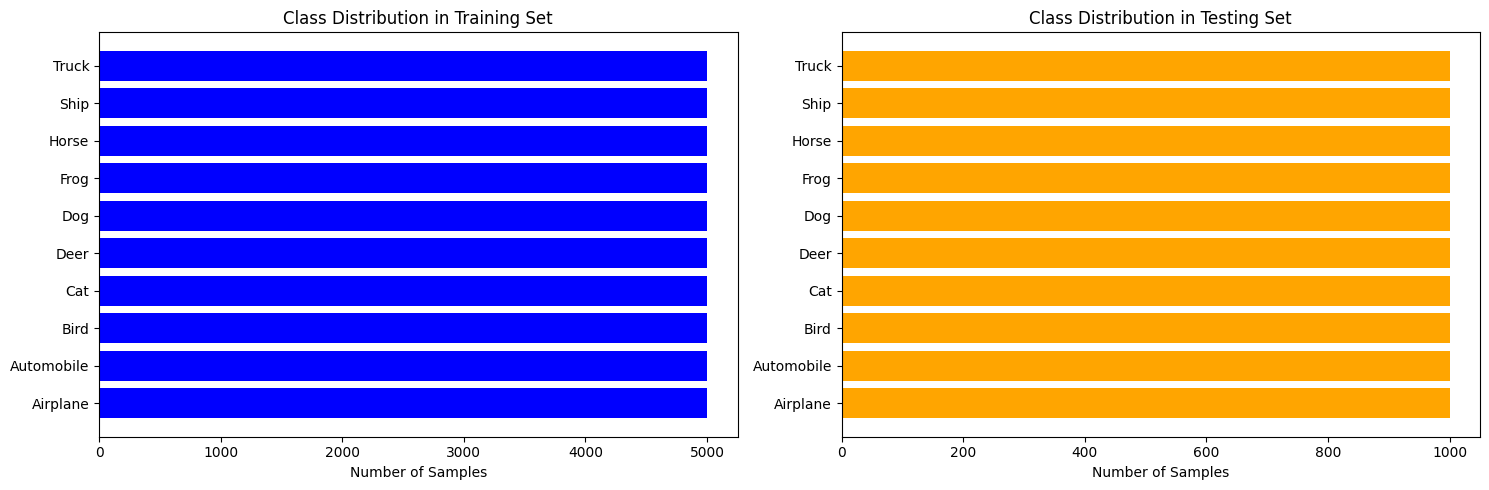

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize the first 81 images
plt.figure(figsize=(15, 15))

for i in range(81):
    plt.subplot(9, 9, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])  # Display image
    plt.title(class_names[y_train[i][0]], fontsize=12)  # Set title with class label

plt.tight_layout()
plt.show()

# Class distribution in training and testing sets
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)

# Plot class distributions
plt.figure(figsize=(15, 5))

# Training set
plt.subplot(1, 2, 1)
plt.barh(classes_name, train_counts, color='blue')
plt.xlabel('Number of Samples')
plt.title('Class Distribution in Training Set')

# Testing set
plt.subplot(1, 2, 2)
plt.barh(classes_name, test_counts, color='orange')
plt.xlabel('Number of Samples')
plt.title('Class Distribution in Testing Set')

plt.tight_layout()
plt.show()
